In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, SequentialSampler
from multimae.utils.plot_utils import plot_predictions
from multimae.utils.train_utils import normalize_depth
from multimae.utils.datasets import build_multimae_pretraining_dataset
from multimae.utils.plot_utils import get_semseg_metadata
from multimae.tools.load_multimae import load_model

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### load checkpoints

In [2]:
model_name = "depth-semseg"
model, args = load_model(model_name)
print(model.output_adapters.keys())

Model loaded from:  /home/chunwei/Documents/drone_offboard/vision_backbones/MultiMAE/results/pretrain/03-12-23-04-05/checkpoint-299.pth
odict_keys(['rgb', 'depth', 'semseg'])


In [3]:
seed = 7
torch.manual_seed(seed) # change seed to resample new mask
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [4]:
# configure for detectron dataset (for prediection)
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
eval_data_path = multimae_path / "datasets/test/val"
metadata = get_semseg_metadata(eval_data_path)

In [5]:
args.eval_data_path = str(eval_data_path)
dataset_val = build_multimae_pretraining_dataset(args, args.eval_data_path)
sampler_val = SequentialSampler(dataset_val)
data_loader_val = DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=1,
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=True,
)

In [6]:
inputs = iter(data_loader_val).next()[0]

if model_name != "no-standard-depth" and "depth" in inputs:
    inputs["depth"] = normalize_depth(inputs["depth"])
inputs = {k: v.to("cuda") for k,v in inputs.items()}

In [7]:
print(inputs["depth"].min())
print(inputs["depth"].max())

tensor(-0.8606, device='cuda:0')
tensor(5.2839, device='cuda:0')


In [8]:
masks = {
    "rgb": torch.ones((1, 14, 14), dtype=torch.long),
    "depth": torch.ones((1, 14, 14), dtype=torch.long),
    "semseg": torch.zeros((1, 14, 14), dtype=torch.long)
}
masks = {k: torch.LongTensor(v).flatten()[None].to("cuda") for k, v in masks.items()}

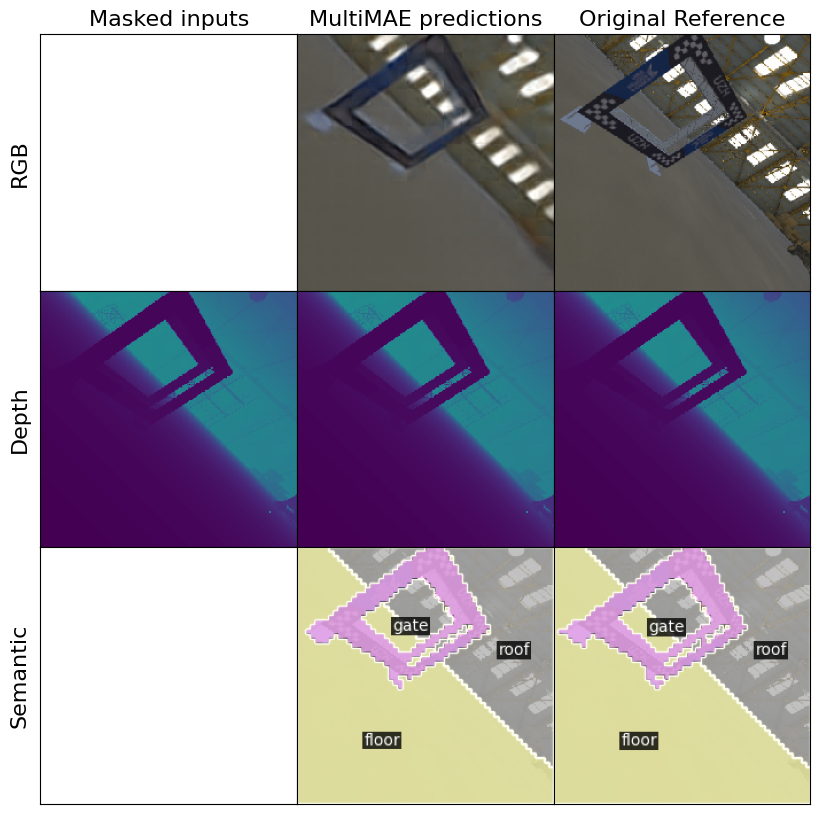

In [9]:
preds, masks = model(
    inputs, 
    num_encoded_tokens=196, 
    alphas=args.alphas, 
    sample_tasks_uniformly=args.sample_tasks_uniformly,
    mask_type=args.mask_type,
    masked_rgb_gate_only=True,
    semseg_gt=inputs["semseg"],
    in_domains=args.in_domains,
    semseg_stride=4,
    mask_inputs=True,
    task_masks=masks,
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

for domain in ["rgb", "depth", "semseg"]:
    if domain not in masks:
        masks[domain] = torch.ones_like(list(masks.values())[0])

res = plot_predictions(inputs, preds, masks, metadata=metadata)

In [10]:
print(preds["depth"].min())
print(preds["depth"].max())

tensor(-1.2771)
tensor(2.9823)
